This notebook covers the second run done with three polystyrene (DVB-crosslinked) particles and one polyethylene particle. 
Just a simple import block to start it off. 

In [1]:

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import re
from re import split

Setting some variables:

In [2]:
mlen = 3 # number states to transition to/from
tlen = 3 # number of ways to measure transition time 
            #-> Either by length of time stable, lenght of time spent transitioning, or both combined

excludedvids=[] # videos which, due to errors in data collection, should not be used

And some functions we'll be using later. 

In [3]:
# Euclidean distance between two vectors
def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

# Divide a row through by its sum
# Used for normalising rows in matrices, which might sum to zero (have no transitions)
def ratio(row):
    sums = np.sum(row)
    if sums > 0:
        return row/sums
    else:
        return row

# Divide all columns through by their sums
def col_norm(array):
    cols = array.T
    cols = np.array([ratio(j)*100 for j in cols])
    return cols.T

# Divide all rows through by their sums
def row_norm(array):
    rows = np.array([ratio(j)*100 for j in array])
    return rows

# Flatten an array of lists 
def flattener(array_of_lists):
    return(np.array([x for y in array_of_lists for x in y]))


def parser_arr(filename): # the data is stored in a text file
    # returns arrays of all transitions, transition times, and list of all class and transition thresholds
    transitions = []
    thresholds = []
    vidarrs = []
    timestotrans = []
    statelists = []
    with open(filename) as textfile:
        line = textfile.readline()
        #print('opened', line)
        while line:
            if 'Processing' in line:
                vidnum = line.split('pp_')[-1]
                vidnum = vidnum.split('.avi')[0]
                vidnum = vidnum.split('_')[0]
                #print(vidnum)
                vidnum = int(vidnum)
                line = textfile.readline()
            if 'T threshold'in line:
                thresh_set = []
                for word in line.split():
                    try:
                        thresh_set.append(float(word)) #collect T_treshold
                    except ValueError:
                        pass
                    
                line = textfile.readline()
                #print('after t', line)
                if 'C threshold' in line:
                    for word in line.split():
                        try:
                            thresh_set.append(float(word)) # colect C_threshold
                        except ValueError:
                            pass
                                          
                    #Initialise collecction arrays for this threshold pair
                    if len(thresholds) ==0 or thresholds[-1] != thresh_set:
                        #print(thresh_set)
                        thresholds.append(thresh_set)
                        #vidnums=[]
                        vidarrs.append([[] for i in range(3)])
                        vidsarr = np.zeros((mlen,mlen))
                        transitions.append(vidsarr)
                        #timestotrans.append(np.zeros((tlen,mlen,mlen)))
                        statelists.append([])
                    else:
                        pass    
                    
                    # Collect transition data
                    line = textfile.readline()
                    #print('array lives here', line)
                    trarr = read_square_arr(line, textfile)
                    transitions[-1] += trarr
                    vidarrs[-1][0].append(trarr)
                    vidarrs[-1][1].append(vidnum)
        
                    # Collect time data
                    #print(len(timestotrans[-1]))
                    tiarrs = []
                    for i in range(tlen):
                        line = textfile.readline()
                        #print('array lives there', line)
                        tiarr = read_square_arr_list(line, textfile) 
                        #print(arr)
                        #times += tiarr   
                        #print(times)
                        tiarrs.append(tiarr)
                        line = textfile.readline()
                        print('arr','\n', tiarr)
                    #print("collected 3 rrays: ", tiarrs)
                    vidarrs[-1][2].append(tiarrs)                       
                    # Collect state data 
                    statelists[-1].append([float(f) for f in filter(int_from_text, split(' |\[|]', line))])
                    #print(thresholds[-1])
                    #print(thresholds[-1])
                else:
                    print("missing C thresh")
                
                
                    
            line = textfile.readline()
            #print(line, 'moved on')
                    
                
            
    textfile.close()
    #print(transitions, thresholds)
    return([np.array(transitions), np.array(thresholds), np.array(vidarrs), np.array(timestotrans), statelists]) 

# Decide if text can be converted to floats
def int_from_text(text):
    try:
        float(text)
        return True
    except:
        return False
    
# Generate an integer given a simple text string
def int_from_text_list(textlist):
    #print('textlist: ', textlist)
    elements = []
    for el in textlist:
        nums = [int(s) for s in  re.findall(r'\d+',el)]
        elements.append(nums)
        #print("nums for element ",el,": ", nums )
    #print('elements total: ', elements)
    return elements

# For each of the many nested arrays in this document,
# read just this one
def read_square_arr(line, textfile):
    if '[[' in line:
        arr = np.zeros((mlen,mlen))
        #print(split(' |\[|]', line))
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        #print(linenums)
        arr[0,:] = linenums

        line = textfile.readline()
        #print('array lives here', line)           
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        #print(linenums)
        arr[1,:] = linenums
        
        
        line = textfile.readline()
        #print('array lives here', line)           
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        #print(linenums)
        arr[2,:] = linenums

        return(arr)
        #print(arr,'\n', transitions[-1])
    else:
        print("missing trans array") # just a warning, in case things go south, like due to a misplaced blank line
        
        
sttr = '\[*list' # the correct separator for the text as it's formatted currently
def read_square_arr_list(line, textfile):
    #print('square array start: ', line)
    if '[[' in line:  # marks the start of an array
        arr =[]
        
        while ')]' not in line: # means the row has not yet terminated so continue to the next line 
            line2 = textfile.readline()
            line += line2
            #print('LINE', line)           
            
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)] #Take out newlines, split at separator, keep only non-whitespace
        #print(prelims)
        linenums = int_from_text_list(prelims)
        #print(linenums)
        arr.append(linenums)

        line = textfile.readline()  # second line of array (there are only 2 for the two states in this case)      
        while ')]' not in line:
            line2 = textfile.readline()
            line += line2
            #print('LINE', line)   
            
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)]
        #print(prelims)
        linenums = int_from_text_list(prelims)
        #print(linenums)
        arr.append(linenums)
        
        line = textfile.readline()  # third line of array (there are only 2 for the two states in this case)      
        while ')]' not in line:
            line2 = textfile.readline()
            line += line2
            #print('LINE', line)   
            
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)]
        #print(prelims)
        linenums = int_from_text_list(prelims)
        #print(linenums)
        arr.append(linenums)

        return(np.array(arr))
        #print(arr,'\n')
    else:
        print("missing times array")


Set the colors for the output plots -> first color is for Top state, second is for c-shape.

In [4]:
cols =[ 'mediumslateblue','fuchsia','darkviolet' ] 

Now to read in some data and check that everything works. 

In [5]:
trans_runs= parser_arr(glob('./realhalf*output.txt')[0]) # the output file with washed styrene information
print(trans_runs[2][:])


arr 
 [[list([751, 372, 263, 970, 250, 834, 149, 515, 152, 910, 283, 459, 821, 258, 271, 426, 503, 380, 257, 1650, 2040, 240])
  list([]) list([295, 2855])]
 [list([]) list([]) list([])]
 [list([352, 261, 67]) list([])
  list([108, 1447, 150, 701, 1041, 1169, 409, 205])]]
arr 
 [[list([3, 237, 105, 803, 105, 523, 68, 119, 0, 812, 158, 354, 679, 142, 164, 174, 342, 214, 126, 1495, 1951, 111])
  list([]) list([127, 2753])]
 [list([]) list([]) list([])]
 [list([201, 0, 9]) list([]) list([2, 1288, 3, 539, 768, 1040, 162, 12])]]
arr 
 [[list([748, 135, 158, 167, 145, 311, 81, 396, 152, 98, 125, 105, 142, 116, 107, 252, 161, 166, 131, 155, 89, 129])
  list([]) list([168, 102])]
 [list([]) list([]) list([])]
 [list([151, 261, 58]) list([])
  list([106, 159, 147, 162, 273, 129, 247, 193])]]
arr 
 [[list([149, 1261, 1021, 1244, 944, 411, 217, 469, 528, 501, 638, 1450, 1377, 954, 1834, 2397, 1546, 915, 664, 1887, 1050, 146, 752, 645, 819, 719])
  list([])
  list([43, 31, 256, 49, 16, 21, 52, 313

Getting the actual observed probability of transition to each state (top, c-shape), per video. 


len indices 2
vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
[[22.  0.  2.]
 [ 0.  0.  0.]
 [ 3.  0.  8.]] counts [59.46969697  0.         40.53030303]
[[26.  0. 23.]
 [ 0.  0.  0.]
 [23.  0.  3.]] counts [70.76138148  0.         29.23861852]
[[11.  0. 21.]
 [ 0.  0.  1.]
 [21.  1. 71.]] counts [18.98521505  0.35842294 80.65636201]
[[10.  0.  3.]
 [ 0.  0.  0.]
 [ 4.  0.  5.]] counts [60.68376068  0.         39.31623932]
[[11.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] counts [100.   0.   0.]
[[2. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]] counts [83.33333333  0.         16.66666667]
Total transitions:  [[82.  0. 50.]
 [ 0.  0.  1.]
 [52.  1. 87.]] [[82.  0. 50.]
 [ 0.  0.  1.]
 [52.  1. 87.]] 

vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
[[26.  0.  2.]
 [ 0.  0.  0.]
 [ 3.  0.  5.]] counts [65.17857143  0.         34.

Text(0, 0.5, 'observed probability of transition')

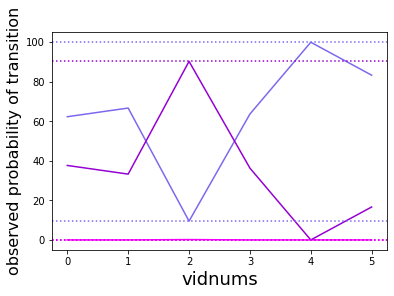

In [6]:
index = list(range(len(trans_runs[0]))) # for all the videos in trans_runs

criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
vidnumset = []
print('\nlen indices', len(index))
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    if True:#len(trans_runs[2][i][0]) == len(vidarrs):
        vidarrs = np.array(trans_runs[2][i][0])
        vidnums = trans_runs[2][i][1]
        print('vidnums', vidnums)
        allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
        print('disallowed numbers', excludedvids)
        print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
        print('allowed indices', allowed_inds)
        vidnums = [vidnums[x] for x in allowed_inds] # Exclude bad videos
        print('vidnums filtered', vidnums)
        vidarrs = vidarrs[allowed_inds]   # Gt the correct statistics for allowed ones
        vidindices = list(range(len(vidarrs)))
        for vidind in vidindices: 
            T_obb = vidarrs[vidind]
            trans_matrices.append(T_obb)
            T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
            #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
            counts =  ratio(np.sum(T_obb_norm, axis=0))*100 # observed transition (to) percentages
            print(T_obb, 'counts', counts)
            #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
                  #np.sum(T_obb, axis=0))
            x1.append(counts[0])
            x2.append(counts[1])
            x3.append(counts[2])
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2, x3])
        print('Total transitions: ',np.sum(vidarrs), np.sum(vidarrs, axis=0), '\n')
#print(t_threshes,c_threshes)    

# Print probabilitie sby video
#stored_y_values = [stored_y_values[x] for x in range(len(stored_y_values))]
stored_y_values = [z for z in stored_y_values if len(z[0]) == len(stored_y_values[0][0])] #np.array(stored_y_values)
print('\nstored_y_values',stored_y_values,'\n', len(stored_y_values), len(stored_y_values[0]), len(stored_y_values[0][1]),stored_y_values[0][1])
y_values_selected = np.array(np.sum(stored_y_values, axis=0))
y_values_selected = col_norm(y_values_selected)
print('\n','\nsummed y values\n', y_values_selected, '\n', len(y_values_selected), len(y_values_selected[0]))
y1,y2,y3 = y_values_selected 
print('\nvidnums',vidnums,y1,y2,y3)
vidnums = list(range(len(y1)))
fig,ax = plt.subplots()
print('\n',len(vidnums), len(y1))        
plt.plot(vidnums, y1, c = cols[0], ls = '-')
plt.plot(vidnums, y2, c = cols[1], ls = '-')
plt.plot(vidnums, y3, c = cols[2], ls = '-')

plt.axhline(y=min(y1), c = cols[0], ls = ':')
plt.axhline(y=min(y2), c = cols[1], ls = ':')
plt.axhline(y=min(y3), c = cols[2], ls = ':')
plt.axhline(y=max(y1), c = cols[0], ls = ':')
plt.axhline(y=max(y2), c = cols[1], ls = ':')
plt.axhline(y=max(y3), c = cols[2], ls = ':')
plt.xlabel('vidnums', fontsize=18)
plt.ylabel('observed probability of transition', fontsize=16)
    
    
#Print probabilities by v threshold
    
    
    
# Printprobabilities by video

Get the observed probabilities, by stability threshold. this si the number of consecutive frames which must be registered as a state before the state changes. Any braak in the chain resets the counting. As you see, the proportions are somewhat sensitive. For time's sake, there are only two thresholds this time. 

vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
[10.0, 30.0] [65.53889791937027, 62.97348484848485] [0.059737156511350066, 0.0] [34.401364924118376, 37.02651515151515]
2 2


Text(0, 0.5, 'observed probability of transition')

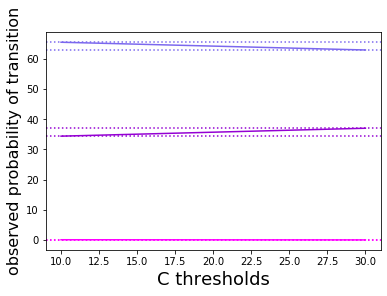

In [7]:
index = list(range(len(trans_runs[0])))

criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    vidarrs = np.array(trans_runs[2][i][0])
    vidnums = trans_runs[2][i][1]
    print('vidnums', vidnums)
    allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
    print('disallowed numbers', excludedvids)
    print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
    print('allowed indices', allowed_inds)
    vidnums = [vidnums[x] for x in allowed_inds]
    print('vidnums filtered', vidnums)
    vidarrs = vidarrs[allowed_inds]   
    vidindices = list(range(len(vidarrs)))
    for vidind in vidindices: 
        T_obb = vidarrs[vidind]
        trans_matrices.append(T_obb)
        T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
        #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
        eigvals, eigvecs = np.linalg.eig(T_obb_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if eigvals[x]==max(eigvals)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        counts =  ratio(np.sum(T_obb_norm, axis=0))*100#/np.sum(T_obb_norm)
        #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
              #np.sum(T_obb, axis=0))
        x1.append(counts[0])
        x2.append(counts[1])
        x3.append(counts[2])
    if len(x1) == len(vidnums):
        #vidarrs = np.cumsum(vidarrs, axis=0)
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2,x3])
#print(t_threshes,c_threshes)    

# Print probabilitie sby c threshold
stored_y_values = np.array(stored_y_values)
cs = list(set(c_threshes))
list.sort(cs)
#print('\n', stored_y_values, '\n', c_threshes, '\n', cs, '\n')
y1 = []
y2 = []
y3 = []
for j in cs:
    inds = np.where(np.array(c_threshes) == j)
    y_values_selected = stored_y_values[inds] # matrix where each row is a t,c that includes the particular c threshold as the c
    #print('\noriginal y values\n', y_values_selected)
    y_values_selected = np.sum(y_values_selected, axis=0)
    #print('\nsummed y values\n',j, y_values_selected)    
    collected_value_across_all_vids = ratio([sum(i) for i in y_values_selected])*100
    #y1,y2,y3 = y_values_selected # one y value per video, and all only for this c threshold, summed over the t thresholds used
    #print(collected_value_across_all_vids, sum(collected_value_across_all_vids))
    y1.append(collected_value_across_all_vids[0])
    y2.append(collected_value_across_all_vids[1])
    y3.append(collected_value_across_all_vids[2])
print(cs,y1,y2, y3)
fig,ax = plt.subplots()
print(len(cs), len(y1))        
plt.plot(cs, y1, c = cols[0], ls = '-')
plt.plot(cs, y2, c = cols[1], ls = '-')
plt.plot(cs, y3, c = cols[2], ls = '-')

plt.axhline(y=min(y1), c = cols[0], ls = ':')
plt.axhline(y=min(y2), c = cols[1], ls = ':')
plt.axhline(y=min(y3), c = cols[2], ls = ':')
plt.axhline(y=max(y1), c = cols[0], ls = ':')
plt.axhline(y=max(y2), c = cols[1], ls = ':')
plt.axhline(y=max(y3), c = cols[2], ls = ':')
plt.xlabel('C thresholds', fontsize=18)
plt.ylabel('observed probability of transition', fontsize=16)
    
    
#Print probabilities by v threshold
    
    
    
# Printprobabilities by video

This is how the transition probabilities vary wrt the transition sthreshold; how many frames does a raft remain broken for before 
it is classified as broken. This only applies in the case of transitions to the same state as the original. Within the threshold 
range used, the probabilities are insensitive to this. 

vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
[60.0] [64.25619138392756] [0.029868578255675033] [35.71394003781677]
1 1


Text(0, 0.5, 'observed probability of transition')

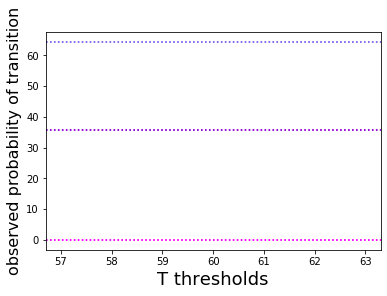

In [8]:
index = list(range(len(trans_runs[0])))

criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    vidarrs = np.array(trans_runs[2][i][0])
    vidnums = trans_runs[2][i][1]
    print('vidnums', vidnums)
    allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
    print('disallowed numbers', excludedvids)
    print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
    print('allowed indices', allowed_inds)
    vidnums = [vidnums[x] for x in allowed_inds]
    print('vidnums filtered', vidnums)
    vidarrs = vidarrs[allowed_inds]   
    vidindices = list(range(len(vidarrs)))
    for vidind in vidindices: 
        T_obb = vidarrs[vidind]
        trans_matrices.append(T_obb)
        T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
        #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
        
        counts =  ratio(np.sum(T_obb_norm, axis=0))*100#/np.sum(T_obb_norm)
        #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
              #np.sum(T_obb, axis=0))
        x1.append(counts[0])
        x2.append(counts[1])
        x3.append(counts[2])
    if len(x1) == len(vidnums):
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2,x3])
#print(t_threshes,c_threshes)    

# Print probabilitie sby t threshold
stored_y_values = np.array(stored_y_values)
ts = list(set(t_threshes))
list.sort(ts)
#print('\n', stored_y_values, '\n', c_threshes, '\n', cs, '\n')
y1 = []
y2 = []
y3 = []
for j in ts:
    inds = np.where(np.array(t_threshes) == j)
    y_values_selected = stored_y_values[inds] # matrix where each row is a t,c that includes the particular c threshold as the c
    #print('\noriginal y values\n', y_values_selected)
    y_values_selected = np.sum(y_values_selected, axis=0)
    #print('\nsummed y values\n',j, y_values_selected)    
    collected_value_across_all_vids = ratio([sum(i) for i in y_values_selected])*100
    #y1,y2,y3 = y_values_selected # one y value per video, and all only for this c threshold, summed over the t thresholds used
    #print(collected_value_across_all_vids, sum(collected_value_across_all_vids))
    y1.append(collected_value_across_all_vids[0])
    y2.append(collected_value_across_all_vids[1])
    y3.append(collected_value_across_all_vids[2])
print(ts,y1,y2, y3)
fig,ax = plt.subplots()
print(len(ts), len(y1))        
plt.plot(ts, y1, c = cols[0], ls = '-')
plt.plot(ts, y2, c = cols[1], ls = '-')
plt.plot(ts, y3, c = cols[2], ls = '-')

plt.axhline(y=min(y1), c = cols[0], ls = ':')
plt.axhline(y=min(y2), c = cols[1], ls = ':')
plt.axhline(y=min(y3), c = cols[2], ls = ':')
plt.axhline(y=max(y1), c = cols[0], ls = ':')
plt.axhline(y=max(y2), c = cols[1], ls = ':')
plt.axhline(y=max(y3), c = cols[2], ls = ':')
plt.xlabel('T thresholds', fontsize=18)
plt.ylabel('observed probability of transition', fontsize=16)
    
    
#Print probabilities by v threshold
    
    
    
# Printprobabilities by video

One weakenss is an inability to recognize transitions that occur by unorthodox motions like sliding of one particle from the edge through the middle (which ahs been observed), if the final state isn't different than the original. 

This is a sun, for each pairt of thresholds, of the observed probailities of transition. 
Because only one run went to completion (one pair of thresholds), there is not a range for indices here, only a single 
value for each state's observed probability. 


len indices 2
vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
vidnums [0 4 5 1 2 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5]
vidnums filtered [0, 4, 5, 1, 2, 3]
criteria ['60,10', '60,30']

stored_y_values [[[59.46969696969697, 70.76138147566719, 18.98521505376344, 60.68376068376069, 100.0, 83.33333333333334], [0.0, 0.0, 0.3584229390681004, 0.0, 0.0, 0.0], [40.53030303030303, 29.23861852433281, 80.65636200716847, 39.31623931623932, 0.0, 16.666666666666668]], [[65.17857142857143, 62.66233766233766, 0.0, 66.66666666666667, 100.0, 83.33333333333334], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [34.82142857142857, 37.33766233766234, 100.0, 33.33333333333333, 0.0, 16.666666666666668]]] 
 2 3 6 [0.0, 0.0, 0.3584229390681004, 0.0, 0.0, 0.0]
[[3.93233388e+02 3.58422939e-01 2.06408190e+02]
 [3.77840909e+02 0.00000000e+00 2.22159091e+02]]

 
summed y values
 [[6.55388979e+01 5.9737

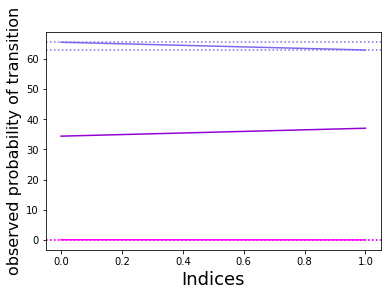

In [9]:
index = list(range(len(trans_runs[0])))
def row_norm(array):
    rows = np.array([ratio(j)*100 for j in array])
    return rows
criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
vidnumset = []
print('\nlen indices', len(index))
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    if True:#len(trans_runs[2][i][0]) == len(vidarrs):
        vidarrs = np.array(trans_runs[2][i][0])
        vidnums = trans_runs[2][i][1]
        print('vidnums', vidnums)
        allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
        print('disallowed numbers', excludedvids)
        print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
        print('allowed indices', allowed_inds)
        vidnums = [vidnums[x] for x in allowed_inds]
        print('vidnums filtered', vidnums)
        vidarrs = vidarrs[allowed_inds]   
        vidindices = list(range(len(vidarrs)))
        for vidind in vidindices: 
            T_obb = vidarrs[vidind]
            trans_matrices.append(T_obb)
            T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
            #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
            
            counts =  ratio(np.sum(T_obb_norm, axis=0))*100#/np.sum(T_obb_norm)
            #print('counts', counts)
            #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
                  #np.sum(T_obb, axis=0))
            x1.append(counts[0])
            x2.append(counts[1])
            x3.append(counts[2])
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2,x3])
#print(t_threshes,c_threshes)    
print('criteria', criteria)
# Print probabilitie sby video
#stored_y_values = [stored_y_values[x] for x in range(len(stored_y_values))]
stored_y_values = [z for z in stored_y_values if len(z[0]) == len(stored_y_values[0][0])] #np.array(stored_y_values)
print('\nstored_y_values',stored_y_values,'\n', len(stored_y_values), len(stored_y_values[0]), len(stored_y_values[0][1]),stored_y_values[0][1])
y_values_selected = np.array(np.sum(stored_y_values, axis=2))
print(y_values_selected)
y_values_selected = row_norm(y_values_selected)
print('\n','\nsummed y values\n', y_values_selected, y_values_selected.T,'\n', len(y_values_selected), len(y_values_selected[0]))
y1,y2, y3 = y_values_selected.T 
print(y1, y2, y3)
fig,ax = plt.subplots()
print(len(criteria), len(y1))   
ts = list(range(len(y1)))
print(ts)
plt.plot(ts, y1, c = cols[0], ls = '-')
plt.plot(ts, y2, c = cols[1], ls = '-')
plt.plot(ts, y3, c = cols[2], ls = '-')

plt.axhline(y=min(y1), c = cols[0], ls = ':')
plt.axhline(y=min(y2), c = cols[1], ls = ':')
#plt.axhline(y=min(y3), c = cols[2], ls = ':')
plt.axhline(y=max(y1), c = cols[0], ls = ':')
plt.axhline(y=max(y2), c = cols[1], ls = ':')
#plt.axhline(y=max(y3), c = cols[2], ls = ':')
plt.xlabel('Indices', fontsize=18)
plt.ylabel('observed probability of transition', fontsize=16)


v1 = y1
v2 = y2
v3=y3

This graph shows what ransition probabilities we expect if the particles were to move along th eperimeter of thr raft, in a 'hinging' motion. The moving particle is on the long axis (as they have fewer contacts),
and it uses a neighbouring particle on he short ais as its hinge. For each state, the particles on either end of the long 
axis are allowed to move either clockwise or counterclockwise, with no ias in either direction. Bonds broken in order to move are not included. 
The bold lines show the expected probailities of transitioning to each state, 
with a given ration of bond stranght, where alpha represents the ratio of a mixed bon (glass-plastic) over a glass-glass bond. 
The inverse of this is called the (relative) glass bond strength. This is the same as the proportion of transitions from the state, at steady state.
The dashed lines represent the observed proportions of transitions. As there is no interesection between the dashed and bold lines, this model does not capture the data. 

5 5


'##### "tESTING HYPOTHESIS WITH all 2 positions for particle to swing to"\n#narrow observations array\n#narrow observations array\nalphas = np.linspace(0, 5, 100,endpoint =False)\n#betas = np.linspace(0, 20, 100,endpoint =False)\nx1 = []\nx2 = []\nx3=[]\nfor i in alphas:\n    #print(\'\nalpha = %s\' %i)\n    T_expected_narrow = np.asarray([[4*i, 2*(i + 1)],\n     [4, 2*(i+1)]])\n    T_expected_broad = T_expected_narrow\n    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])\n    #print(T_expected_broad_norm, \'\n\n\', np.around(T_expected_broad_norm, 2))\n    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)\n    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]\n    eigvec_one = eigvecs[:, eig_one_index]\n    evec_one = eigvec_one*100 / np.sum(eigvec_one)\n    #print("Eigenvector for eigenvalue 1 of T_ob_norm:")\n    #print(evec_one)\n    #plt.plot((i, i,

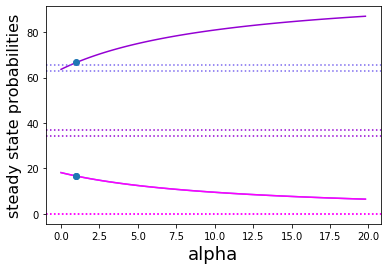

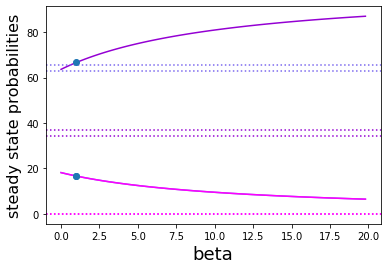

In [10]:
"tESTING HYPOTHESIS WITH all 2 positions for particle to swing to"
alphas = np.linspace(0, 20, 100,endpoint =False)#glass
betas = np.linspace(0, 20, 100,endpoint =False)#plastic
x1 = []
x2 = []
x3 = []
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    if i ==1:
        alpha1 = aln
    for bln in range(len(betas)):
    #print('\nalpha = %s' %i)
        j = betas[bln]
        if j == 1:
            beta1 = bln
        
        T_expected_narrow = np.asarray([[0, 0, 4*(i+1)],
         [0, 0, 4*(j+1)],
                                       [2, 2, 2+i+j]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        a.append(evec_one[0])
        b.append(evec_one[1])
        c.append(evec_one[2])
    x1.append(a)
    x2.append(b)
    x3.append(c)
print(alpha1,beta1)
fig,ax = plt.subplots()
plt.plot(alphas, [x[beta1] for x in x1], c = cols[0], ls = '-')
plt.plot(alphas, [x[beta1] for x in x2], c = cols[1], ls = '-')
plt.plot(alphas, [x[beta1] for x in x3], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('alpha', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')

fig,ax = plt.subplots()
plt.plot(betas, x1[alpha1], c = cols[0], ls = '-')
plt.plot(betas, x2[alpha1], c = cols[1], ls = '-')
plt.plot(betas, x3[alpha1], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('beta', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')
"""##### "tESTING HYPOTHESIS WITH all 2 positions for particle to swing to"
#narrow observations array
#narrow observations array
alphas = np.linspace(0, 5, 100,endpoint =False)
#betas = np.linspace(0, 20, 100,endpoint =False)
x1 = []
x2 = []
x3=[]
for i in alphas:
    #print('\nalpha = %s' %i)
    T_expected_narrow = np.asarray([[4*i, 2*(i + 1)],
     [4, 2*(i+1)]])
    T_expected_broad = T_expected_narrow
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
    #print(evec_one)
    #plt.plot((i, i, i), (evec_one), 'x')
    x1.append(evec_one[0])
    x2.append(evec_one[1])
    x3.append(evec_one[2])
#print(alpha1,beta1)
fig,ax = plt.subplots()
plt.plot(alphas, x1, c = cols[0], ls = '-')
plt.plot(alphas, x2, c = cols[1], ls = '-')
plt.plot(alphas, x3, c = cols[2], ls = '-')
#plt.plot(alphas, [x[beta1] for x in x3], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('alpha', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(1/6,1/6,4/6), 'o')
"""

This is the same as before, but the bond formed (weighted by their strenghts) are divided by the bonds broken, which provides as cost to motion. 
In the 3-polystyren case, this does capture the data, indicated by both pairs of coloured lines crossing at about the same alpha value. 

This means tha the transition statistics we see are possible using only hinge mtion (although both types of motion do inf act occur). 

In other cases, such as some 3-polyethylene runs, it is not possible to reocver the statistics using only hinge mption. 



5 5


'tESTING HYPOTHESIS WITH all position, early state important, end sate proportional to bond strengths"\n#narrow observations array\nalphas = np.linspace(0, 6, 100,endpoint =False)\n#betas = np.linspace(0, 20, 100,endpoint =False)\nx1 = []\nx2 = []\nx3=[]\nfor i in alphas:\n    #print(\'\nalpha = %s\' %i)\n    T_expected_narrow = np.asarray([[2, i + 1],\n     [4/(i+1), 2]])\n    T_expected_broad = T_expected_narrow\n    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])\n    #print(T_expected_broad_norm, \'\n\n\', np.around(T_expected_broad_norm, 2))\n    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)\n    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]\n    eigvec_one = eigvecs[:, eig_one_index]\n    evec_one = eigvec_one*100 / np.sum(eigvec_one)\n    #print("Eigenvector for eigenvalue 1 of T_ob_norm:")\n    #print(evec_one)\n    #plt.plot((i, i, i), 

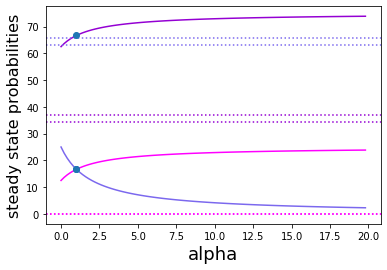

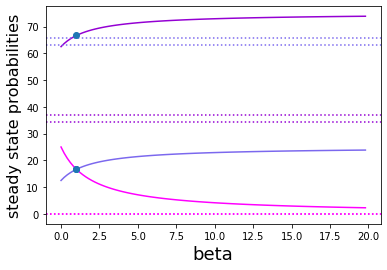

In [11]:
"tESTING HYPOTHESIS WITH all position, early state important, end sate proportional to bond strengths"
#narrow observations array
alphas = np.linspace(0, 20, 100,endpoint =False)
betas = np.linspace(0, 20, 100,endpoint =False)
x1 = []
x2 = []
x3 = []
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    if i ==1:
        alpha1 = aln
    for bln in range(len(betas)):
    #print('\nalpha = %s' %i)
        j = betas[bln]
        if j == 1:
            beta1 = bln
        
        T_expected_narrow = np.asarray([[0, 0, 2*(i+1)],
         [0, 0, 2*(j+1)],
                                       [2/(i+1), 2/(1+j), 2]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        a.append(evec_one[0])
        b.append(evec_one[1])
        c.append(evec_one[2])
    x1.append(a)
    x2.append(b)
    x3.append(c)
print(alpha1,beta1)
fig,ax = plt.subplots()
plt.plot(alphas, [x[beta1] for x in x1], c = cols[0], ls = '-')
plt.plot(alphas, [x[beta1] for x in x2], c = cols[1], ls = '-')
plt.plot(alphas, [x[beta1] for x in x3], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('alpha', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')

fig,ax = plt.subplots()
plt.plot(betas, x1[alpha1], c = cols[0], ls = '-')
plt.plot(betas, x2[alpha1], c = cols[1], ls = '-')
plt.plot(betas, x3[alpha1], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('beta', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')
"""tESTING HYPOTHESIS WITH all position, early state important, end sate proportional to bond strengths"
#narrow observations array
alphas = np.linspace(0, 6, 100,endpoint =False)
#betas = np.linspace(0, 20, 100,endpoint =False)
x1 = []
x2 = []
x3=[]
for i in alphas:
    #print('\nalpha = %s' %i)
    T_expected_narrow = np.asarray([[2, i + 1],
     [4/(i+1), 2]])
    T_expected_broad = T_expected_narrow
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
    #print(evec_one)
    #plt.plot((i, i, i), (evec_one), 'x')
    x1.append(evec_one[0])
    x2.append(evec_one[1])
    x3.append(evec_one[2])
#print(alpha1,beta1)
fig,ax = plt.subplots()
plt.plot(alphas, x1, c = cols[0], ls = '-')
plt.plot(alphas, x2, c = cols[1], ls = '-')
plt.plot(alphas, x3, c = cols[2], ls = '-')
#plt.plot(alphas, [x[beta1] for x in x3], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('alpha', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(1/6,1/6,4/6), 'o')"""


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


5 5


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\

'tESTING HYPOTHESIS WITH all position, early state unimportant, end sate proportional to bond strengths"\n#narrow observations array\nalphas = np.linspace(0, 6, 100,endpoint =False)\n#betas = np.linspace(0, 20, 100,endpoint =False)\nx1 = []\nx2 = []\nfor i in alphas:\n    #print(\'\nalpha = %s\' %i)\n    t = (2/((1+i)*(2+2*i))+\n         4*i/((1+i)*(2+2*i)*(4+2*i))+\n          2*i/((1+i)*(4+2*i)))\n    #print(bm)\n    c = (2*i/((1+i)*(4+2*i))+\n          i*(2+2*i)/((1+i)*(4+2*i)))\n    \n    T_expected_narrow = np.asarray([[t, c],\n     [t, c]])\n    T_expected_broad = T_expected_narrow\n    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])\n    #print(T_expected_broad_norm, \'\n\n\', np.around(T_expected_broad_norm, 2))\n    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)\n    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]\n    eigvec_one = eigvecs[

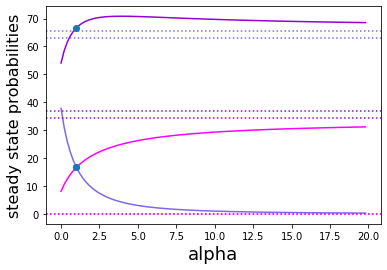

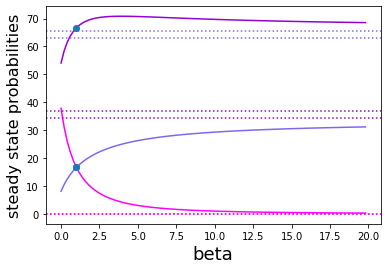

In [13]:
"tESTING HYPOTHESIS WITH all position, ba"
#narrow observations array
alphas = np.linspace(0, 20, 100,endpoint =False)
betas = np.linspace(0, 20, 100,endpoint =False)
x1 = []
x2 = []
x3 = []
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    if i ==1:
        alpha1 = aln
    for bln in range(len(betas)):
    #print('\nalpha = %s' %i)
        j = betas[bln]
        if j == 1:
            beta1 = bln
        
        p = (j*2/(18*(1+i+j)*(3+i))+
             4*2*(j+1)/(18*2*(3+i)*(1+i+j)*(2+i+j)))
        g = (i*2/(18*(1+i+j)*(3+j))+
             4*2*(i+1)/(18*2*(3+j)*(1+i+j)*(2+i+j)))
        m = (2*j*(i+1)/(18*(3+i)*(1+j+i))+
              8*(i+1)*(j+1)/(18*2*(3+j)*(i+j+1)*(i+j+2))+
              8*(j+1)*(i+1)/(18*2*(3+i)*(i+j+1)*(i+j+2))+
              i*2*(1+j)/(18*(3+j)*(1+i+j)))

        T_expected_narrow = np.asarray([[p, g, m],
                                        [p, g, m],
         [p, g, m]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        a.append(evec_one[0])
        b.append(evec_one[1])
        c.append(evec_one[2])
    x1.append(a)
    x2.append(b)
    x3.append(c)
print(alpha1,beta1)
fig,ax = plt.subplots()
plt.plot(alphas, [x[beta1] for x in x1], c = cols[0], ls = '-')
plt.plot(alphas, [x[beta1] for x in x2], c = cols[1], ls = '-')
plt.plot(alphas, [x[beta1] for x in x3], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('alpha', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')

fig,ax = plt.subplots()
plt.plot(betas, x1[alpha1], c = cols[0], ls = '-')
plt.plot(betas, x2[alpha1], c = cols[1], ls = '-')
plt.plot(betas, x3[alpha1], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('beta', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')
"""tESTING HYPOTHESIS WITH all position, early state unimportant, end sate proportional to bond strengths"
#narrow observations array
alphas = np.linspace(0, 6, 100,endpoint =False)
#betas = np.linspace(0, 20, 100,endpoint =False)
x1 = []
x2 = []
for i in alphas:
    #print('\nalpha = %s' %i)
    t = (2/((1+i)*(2+2*i))+
         4*i/((1+i)*(2+2*i)*(4+2*i))+
          2*i/((1+i)*(4+2*i)))
    #print(bm)
    c = (2*i/((1+i)*(4+2*i))+
          i*(2+2*i)/((1+i)*(4+2*i)))
    
    T_expected_narrow = np.asarray([[t, c],
     [t, c]])
    T_expected_broad = T_expected_narrow
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
    #print(evec_one)
    #plt.plot((i, i, i), (evec_one), 'x')
    x1.append(evec_one[0])
    x2.append(evec_one[1])
#print(alpha1,beta1)
fig,ax = plt.subplots()
plt.plot(alphas, x1, c = cols[0], ls = '-')
plt.plot(alphas, x2, c = cols[1], ls = '-')
#plt.plot(alphas, [x[beta1] for x in x3], c =  cols[2], ls = '-')

plt.axhline(y=min(v1), c = cols[0], ls = ':')
plt.axhline(y=min(v2), c =  cols[1], ls = ':')
#plt.axhline(y=min(v3), c = cols[2], ls = ':')
plt.axhline(y=max(v1), c = cols[0], ls = ':')
plt.axhline(y=max(v2), c =  cols[1], ls = ':')
#plt.axhline(y=max(v3), c = cols[2], ls = ':')
plt.xlabel('alpha=mixed/glass', fontsize=18)
plt.ylabel('steady state probabilities', fontsize=16)
#plt.plot((1, 1, 1),(23, 42, 35), 'x')
plt.plot((1, 1),(50,50), 'o')

"""

The proportion of hinge motion varies probably with different runs, and there's not a way to know how much hinging vs breaking apart 
takes place, unless there is an independent onstraint on the bond strengths. 
This grpah shows the flexibility one has in modeling the transitiosn by chosing some linear combination of the break apart and hinging matrices. 

the far left of this graph shows the mixed bond / glass-glass bodn inferred if there was only breaking apart, and the far left shows for only hinging. 

In the event of the green line crossing the x axis, that is the largest proportion of hingin motion which could occur, and at this point it is as if the glass bond was infinitely larger than the mixed bond. 
Then, the data looks as isf the glass particles never moved, and the polystyrene particles moved freely around their perimeter 
when hinging takes place, and likewise that they're far mroe attractive during reassembl atter a break apart. 
This happens in some 3-polyethylene runs, when it's not possible to use more than [] percent hinging to explian the data. 

'#narrow observations array\nfig, ax = plt.subplots()\nalphas = np.linspace(1, 8, 80)\nratios = np.linspace(0, 1, 80)\ntolerances = [(min(v1)*0.9, max(v1)*1.1), (100-max(v1)*1.1, 100-min(v1)*0.9)]# [(min(v1), max(v1)), (min(v2), max(v2))]\nprint(tolerances)\n\n\nfor i in alphas:\n    for r in ratios:\n        #print(\'\nalpha = %s\' %i)\n        #print(tm)\n        t = (2/((1+i)*(2+2*i))+\n         4*i/((1+i)*(2+2*i)*(4+2*i))+\n          2*i/((1+i)*(4+2*i)))\n        #print(bm)\n        c = (2*i/((1+i)*(4+2*i))+\n              i*(2+2*i)/((1+i)*(4+2*i)))\n\n        T2 = np.asarray([[t, c],\n         [t, c]])\n        T1 = np.asarray([[2, i + 1],\n         [4/(i+1), 2]])\n        T_expected_narrow = r*T1 + (1-r)*T2\n        #print(T_expected_narrow)\n        T_expected_broad = T_expected_narrow\n        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])\n        #print(T_expected_broad_norm, \'\n\n\', np.around(T_exp

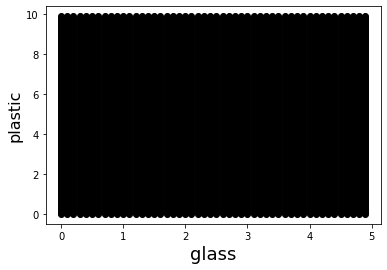

In [14]:
def mean(li):
    return(sum(li) / len(li))
def rang(li):
    return(abs(max(li)-min(li)))

alphas = np.linspace(0,5, 50,endpoint =False)#glass
betas = np.linspace(0, 10, 100,endpoint =False)
x1 = []
x2 = []
x3 = []
tolerances = [ mean(v1),mean(v2),mean(v3)]
tols = [ rang(v1),rang(v2),rang(v3)]
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    
    for bln in range(len(betas)):
    #print('\nalpha = %s' %i)
        j = betas[bln]
        
        T_expected_narrow = np.asarray([[0, 0, 2*(i+1)],
         [0, 0, 2*(j+1)],
                                       [2/(i+1), 2/(1+j), 2]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        test = all(math.isclose(evec_one[i], tolerances[i], abs_tol = tols[i]*1.5)  for i in range(len(evec_one)))
        if test:
            col = "green"
        else:
            col = "k"
        plt.plot(i,j, c=col, marker='o')
        plt.xlabel('glass', fontsize=18)
        plt.ylabel('plastic', fontsize=16)
        
#plt.plot(np.linspace(glas_old[0], glas_old[1], 10), np.linspace(plas_old[0], plas_old[1], 10), marker='x', c='r')

"""#narrow observations array
fig, ax = plt.subplots()
alphas = np.linspace(1, 8, 80)
ratios = np.linspace(0, 1, 80)
tolerances = [(min(v1)*0.9, max(v1)*1.1), (100-max(v1)*1.1, 100-min(v1)*0.9)]# [(min(v1), max(v1)), (min(v2), max(v2))]
print(tolerances)


for i in alphas:
    for r in ratios:
        #print('\nalpha = %s' %i)
        #print(tm)
        t = (2/((1+i)*(2+2*i))+
         4*i/((1+i)*(2+2*i)*(4+2*i))+
          2*i/((1+i)*(4+2*i)))
        #print(bm)
        c = (2*i/((1+i)*(4+2*i))+
              i*(2+2*i)/((1+i)*(4+2*i)))

        T2 = np.asarray([[t, c],
         [t, c]])
        T1 = np.asarray([[2, i + 1],
         [4/(i+1), 2]])
        T_expected_narrow = r*T1 + (1-r)*T2
        #print(T_expected_narrow)
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        test = all((evec_one[i]>= tolerances[i][0] and evec_one[i]<= tolerances[i][1])  for i in range(len(evec_one)))
        if test:
            col = "green"
        else:
            col = "k"
        plt.plot(r, i, c=col, marker='o')
plt.ylabel('bond strength', fontsize=18)
plt.xlabel('proprtion of hinge motion', fontsize=16)"""

In [15]:
Now to collect data on the ttransitions times. 

SyntaxError: invalid syntax (<ipython-input-15-29facdd3a2ac>, line 1)

In [ ]:
# GEt regime of transitions
#parser_arr(glob('./timestotrans.txt')[0])

trans_runs= parser_arr(glob('./wash*styrene.txt')[0])
reduced_times = dict()
t_threshes = []
c_threshes = []    
index = list(range(len(trans_runs[0])))

vidnumset = []
print('\nlen indices', len(index))
for i in index:
    #xs_tr = []
    #xs_ti = []
    trans_matrices = []
    times_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    #print(np.shape(trans_runs[2]))
    transarrs = np.array(trans_runs[2][i][0])
    timarrs = np.array(trans_runs[2][i][2]) ##########
    vidnums = trans_runs[2][i][1]
    print('vidnums', vidnums)
    allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
    print('disallowed numbers', excludedvids)
    print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
    print('allowed indices', allowed_inds)
    vidnums = [vidnums[x] for x in allowed_inds]
    print('vidnums filtered', vidnums)
    transarrs = transarrs[allowed_inds]
    timarrs = timarrs[allowed_inds]
    #print(row_norm(vidarrs))
    #vidarrs = np.cumsum(vidarrs, axis=0)
    vidindices = list(range(len(transarrs)))
    #print(vidnums)
    for vidindex in vidindices: 
        Tr_obb = transarrs[vidindex]
        trans_matrices.append(Tr_obb)
        #print('Transitions ob', Tr_obb)
        Ti_obb = timarrs[vidindex] ##################
        times_matrices.append(Ti_obb)
        #print('Times ob', Ti_obb)
    #print("\nTransitions", trans_matrices)
    #print("\n\nTimes", times_matrices)
    t_threshes.append(trans_threshes[0])
    c_threshes.append(trans_threshes[1])
    

    
    #print(len(times_matrices), len(times_matrices[0]))
    #print(np.shape(times_matrices[0][0]))
    timestotrans = np.array(times_matrices)
    print('tt_shape', np.shape(timestotrans))
    #print(type(timestotrans))
    timestotrans = np.moveaxis(timestotrans, [0,1,2,3], [3, 0,1,2])
    print('tt_shape', np.shape(timestotrans))
    #print(timestotrans[0], '\n\n',type(timestotrans[0][0][0]), timestotrans[0][0][0], [x for y in timestotrans[0][0][0] for x in y])
    indices = np.shape(timestotrans)
    #print(len(indices))
    reduced_timestotrans = np.empty(indices[0:-2], dtype = object)
    #print(reduced_timestotrans)
    for m in range(indices[0]):
        time = timestotrans[m]
        for j in range(indices[1]):
            fromrow = time[j]
            collector = []
            for k in range(indices[2]):
                tocolumn = fromrow[k]
                #print("TOCOLUMN", tocolumn)
                tocolumn = np.array(flattener(tocolumn))
                #print("flattened", tocolumn)
                
                collector.extend(tocolumn)
            if collector ==[]: #if there's nothing in a ROW
                reduced_timestotrans[m,j]= collector# [np.nan] # set the from row
            else:
                reduced_timestotrans[m,j] = collector
            #print('timesrow',reduced_timestotrans[m,j] )
    #timestotrans = np.concatenate(timestotrans, axis=-1)
    print('SHAPE', np.shape(reduced_timestotrans))
    print('reduced', reduced_timestotrans[0])
    print('len of rows per time ', [[len(i) for i in x] for x in reduced_timestotrans])
    print(len([x for y in np.ravel(timestotrans) for x in y]), len([i for x in np.ravel(reduced_timestotrans) for i in x]))
    reduced_times[i] = reduced_timestotrans
    #reduced_timestotrans = per time, pper origin, list of transitions times
    


From the means and variance of the stability times, one can see that the states are on average stbale for the same lenghts of time,
but that there is more variance with the c-state, which also has a relatively huge bias towards short er times as well as some rare long ones. 

Disregarding the long ones, which are infrequeny, the c-shape

In [ ]:
import seaborn 
labels = ["Top", "C-shape"]

def binnerseq(seq, nbins, discardfrac):
    maximum = np.nanmax([x for y in seq for x in y])
    print('MAX', maximum)
    rang = maximum
    bins = list(np.linspace(0, np.round(maximum/discardfrac), nbins-1))
    #bins.append(maximum) 
    print('BINS', bins)
    return np.array(bins)



    

for i in index[0:1]:    
    total_time = (reduced_times[i])[0]
    stable_time= (reduced_times[i])[1]
    unstable_time= (reduced_times)[i][2]
    #print(stable_time.T)
    # for each time, separate the three axes
    times = [total_time, stable_time, unstable_time]
    print("Times: ")
    for i in times:
        print('means, ',[np.round(np.nanmean(x)) for x in i])        
        print('vaars, ',[np.round(np.nanvar(x)) for x in i])
        print(i, '\n')
    timenames = ["Frames between transitions", "Frames stable", "Frames unstable"]
    time = times[1]
    timename = timenames[1]
    #times, timenames = times[1:2], timenames[1:2]
    
    
    fig, ax = plt.subplots(figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))   
    ax.set_prop_cycle(color=cols)
    print(time)
    #
    #time = [time[0]]
    ax.hist(time, bins=binnerseq(time,  60, 1))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    fig, ax = plt.subplots(figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  60, 6))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    
    fig, ax = plt.subplots( figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))  
    ax.set_prop_cycle(color=cols)
    ax.boxplot(time, labels = labels)####
    ax.set_ylabel(timenames)
    ax.set_xlabel("Type of shape")
    ax.legend(labels)

The transition times are heavily biased towards short times of stability for the c-shape, which is the most observed. This state has frequent transitions to na dfrom, 
and it is in a sense most favoured since ti s most visited, but it is less stable also, as the visits are brief. 
In contrat, the top state, which is rarely observed,  is stable for all lengths of time equally. 

I think this is just a byproduct of the frequency of transitions; the c state has more short-lived periods because it 
has more periods overall. 



Or, that there is an attractor in that, once you leve as tate, it is most easy to return to it, so the more times one 
spends in a state the mroe one attracts brief semi-transitions where a particle attempts t leave and the ncomes back. 


Really, 
the reasont huis happens is becuas e when these particles breal away they're really energetic, and it takes multiple hops to release all fo that energy. this measn there are a lost of break aparats probably, within a short interval, and this interval lenghtens as the reaft calms dow. this matches observations, by th eway. And the reate of decay is then exponential, for the energy. The same thing is happening probably to 'transitions'within state, which are not 'real'transitions, but fluctuations of a raft where it breaks apart but not far enough to let each particle go freely away, and they all fall down. The distance outward they go and the number fo times this repeats will dpeend on th eenergy the raft has, and I cna see short frequent burst beng a comon occurence, which would cause lots of fhosrt lived state records being made. 

The other reason fro such short stability times is that it is clear from the very low counts that some states are underrecorded, i.e. that jsut the tai lend of the statss lifetime is recorded. This explains the extremly high incidence of small times but it is a effect that shoud taper off and has it's own curve that's probably not an exponential decay, s it desn't explain that part (the self similarity, ie tha all the later brakcets looks like this). It means that these historgrams are onyl for the transitions from the very most stable states and a lot fo faster state pass-throughs are beign missed. They can be caught with a lower threshold.. 

To clarify, lots of lowe thresholds need to be sampled to get the erro and make sure that at low stbailti yT's, the dats is not ebing swamped by noise from the fluctuatin gclassificaion error, which is also a thing. 
